In [1]:
import json
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from pathlib import Path
import pprint
import matplotlib.pyplot as plt
from dataclasses import asdict
import numpy as np
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import jax
import jax.numpy as jnp
import orbax.checkpoint
from sklearn.metrics import roc_auc_score

from meta_transformer.data import load_batches
from meta_transformer import utils, preprocessing, output_dir
from meta_transformer.meta_model import MetaModelClassifier
from backdoors import paths


figdir = "../../writeups/iclr-2023/figures/"

### Detecting backdoors

In [2]:
# - plot ROC curve for each poison type
# - plot ROC curves for OOD test sets
# - compare AUROC to baseline (meta neural analysis and universal litmus patterns)

CHUNK_SIZE = 128
NUM_SAMPLES = 200
POISON_TYPES = [
    "ulp_test_ood",
    "center_pattern_ood",
    "random_border_pos_pattern",
    "simple_pattern_ood",  # not really OOD
    "single_pixel",
    "random_noise",
]


PLOT_NAMES = {
    "ulp_test_ood": "ULP Test (OOD)",
    "center_pattern_ood": "BadNets Centered (OOD)",
    "random_border_pos_pattern": "BadNets Border",
    "simple_pattern_ood": "BadNets Corner",
    "single_pixel": "Single Pixel",
    "random_noise": "Random Noise",
}


def normalize(x):
    return (x + 0.242) / 3.14


def _load_data(path):
    data = load_batches(path, max_datapoints=NUM_SAMPLES)
    if not len(data) == NUM_SAMPLES:
        raise ValueError(f"Only {len(data)} samples loaded from {path}.")
    return utils.tree_stack([x["params"] for x in data])


@jax.jit
def _process_base_models(params):
    flat = jax.vmap(
        lambda p: preprocessing.chunk(p, CHUNK_SIZE)[0]
        )(params)
    return normalize(flat)


def load_base_models(path):
    data = _load_data(path)
    return _process_base_models(data)

In [3]:
clean = load_base_models(paths.TEST_CLEAN / "clean_1")

backdoored = {}
for p in POISON_TYPES:
    if p.endswith("_ood"):
        ood_data_path = paths.PRIMARY_BACKDOOR / p[:-4]
        backdoored[p] = load_base_models(ood_data_path)
    else:
        backdoored[p] = load_base_models(paths.TEST_BACKDOOR / p)

In [4]:
checkpointer = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
hpc_checkpoint_dir = output_dir + "/hpc-mm-checkpoints"
local_checkpoint_dir = "/home/lauro/projects/meta-models/meta-transformer/outputs/mm-checkpoints"
checkpoint_dirs = {
    "random_border_pos_pattern": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "center_pattern_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "ulp_test_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "simple_pattern_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "single_pixel": local_checkpoint_dir + "/single_pixel",
    "random_noise": local_checkpoint_dir + "/random_noise",
}

run_names = {
    "random_border_pos_pattern": "run_1695834256",
    "center_pattern_ood": "run_1695834256",
    "ulp_test_ood": "run_1695834256",
    "simple_pattern_ood": "run_1695834256",
    "single_pixel": "run_1695862808",
    "random_noise": "run_1695874903",
}

#assert len(checkpoint_dirs) == len(run_names) == len(POISON_TYPES)


def restore_mm(poison_type):
    dir_path, run_name = checkpoint_dirs[poison_type], run_names[poison_type]
    print(f"Restoring from {dir_path}")
    params = checkpointer.restore(os.path.join(dir_path, run_name))
    with open(os.path.join(dir_path, "info.json")) as f:
        info = json.load(f)

    assert info["chunk_size"] == CHUNK_SIZE
    model_config = info["model_config"]
    model = MetaModelClassifier(**model_config)
    return model, params

In [5]:
def get_logits(poison_type):
    model, params = restore_mm(poison_type)
    logits_on_clean, _ = model.apply({"params": params}, clean)
    logits_on_backdoored, _ = model.apply({"params": params}, backdoored[poison_type])
    return logits_on_clean, logits_on_backdoored


def roc_from_logits(logits_on_clean, logits_on_poisoned) -> float:
    all_logits = np.concatenate([logits_on_clean, logits_on_poisoned])
    labels = np.concatenate([np.zeros_like(logits_on_clean), np.ones_like(logits_on_poisoned)])
    return roc_auc_score(labels, all_logits)


def get_rates(poison_type):
    """Get false positive and true positive rates for a range of thresholds."""
    logits_on_clean, logits_on_backdoored = get_logits(poison_type)
    all_logits = np.concatenate([logits_on_clean, logits_on_backdoored])
    labels = np.concatenate([np.zeros_like(logits_on_clean), np.ones_like(logits_on_backdoored)])
    roc = roc_auc_score(labels, all_logits)

    tmin, tmax = all_logits.min(), all_logits.max()
    print("clean logits range:", logits_on_clean.min(), logits_on_clean.max())
    print("backdoored logits range:", logits_on_backdoored.min(), logits_on_backdoored.max())

    thresholds = np.arange(tmin, tmax, 0.05)
    fpr = {}
    tpr = {}
    for t in thresholds:
        fpr[t] = np.mean((logits_on_clean > t) == 1)
        tpr[t] = np.mean((logits_on_backdoored > t) == 1)
    return fpr, tpr, roc

Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/hpc-mm-checkpoints/random_border_pos_pattern
clean logits range: -10.211539 4.1428013
backdoored logits range: -3.390984 11.701251
Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/hpc-mm-checkpoints/random_border_pos_pattern
clean logits range: -10.211539 4.1428013
backdoored logits range: -3.1206355 11.703102
Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/hpc-mm-checkpoints/random_border_pos_pattern
clean logits range: -10.211539 4.1428013
backdoored logits range: -3.580478 11.701501
Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/hpc-mm-checkpoints/random_border_pos_pattern
clean logits range: -10.211539 4.1428013
backdoored logits range: -6.1960936 11.697776
Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/mm-checkpoints/single_pixel
clean logits range: -14.345178 1.5029913
backdoored logits range: -1.53503 20.471

[]

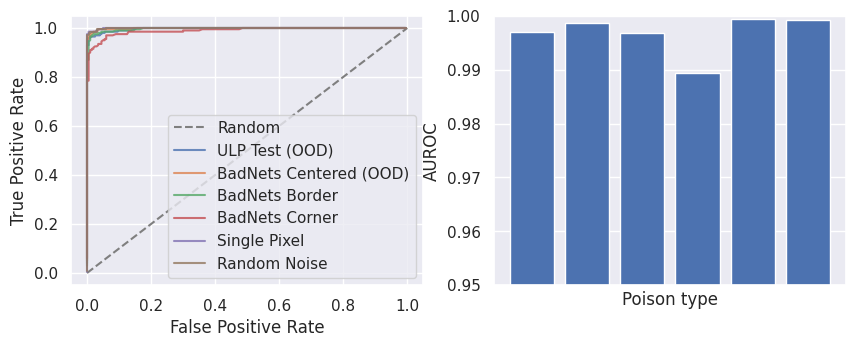

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

ax = axs[0]
ax.plot([0, 1], [0, 1], '--', label="Random", color="tab:grey")

ROC_ALPHA = 0.8


reported_rocs = {
    "mns_oneclass_simple_pattern": 0.6399,
    "mns_jumbo_simple_pattern": 0.9195,
    "mns_oneclass_random_noise": 0.7377,
    "mns_jumbo_random_noise": 0.9545,
    "ulp": 1.0,
}



rocs = {}
for ptype in POISON_TYPES:
    fpr, tpr, roc = get_rates(ptype)
    rocs[ptype] = roc
    ax.plot(fpr.values(), tpr.values(), label=PLOT_NAMES[ptype], alpha=ROC_ALPHA)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
#ax.set_ylim((-0.01, 1.01))
#ax.set_xlim((-0.01, 1.01))
ax.legend()

ax = axs[1]
ax.bar(range(len(rocs)), rocs.values())
ax.set_ylabel("AUROC")
ax.set_xlabel("Poison type")
ax.set_ylim((0.95, 1))
ax.set_xticklabels([])
ax.set_xticks([])
#ax.set_xticklabels(PLOT_NAMES.values(), rotation=90)
#ax.set_xticks(range(len(POISON_TYPES)))

#plt.tight_layout()
#plt.savefig(figdir + "backdoors_roc.pdf", bbox_inches="tight")

In [8]:
rocs

{'ulp_test_ood': 0.9970249999999999,
 'center_pattern_ood': 0.998675,
 'random_border_pos_pattern': 0.99685,
 'simple_pattern_ood': 0.9894499999999999,
 'single_pixel': 0.9993749999999999,
 'random_noise': 0.9993}

In [13]:
ROCS_TO_PLOT

['ulp_test_ood',
 'center_pattern_ood',
 'random_border_pos_pattern',
 'simple_pattern_ood',
 'random_noise']

In [14]:
reported_rocs

{'mns_oneclass_simple_pattern': 0.6399,
 'mns_jumbo_simple_pattern': 0.9195,
 'mns_oneclass_random_noise': 0.7377,
 'mns_jumbo_random_noise': 0.9545,
 'ulp': 1.0}

In [ ]:
# 0 random border pos (iid)
# 1 center_pattern (ood)
# 2 simple pattern: ours vs mns_oneclass vs mns_jumbo
# 3 random noise: ours vs mns_oneclass vs mns_jumbo
# 4 ulp: ours (ood) vs ulp

In [26]:
for ptype in ROCS_TO_PLOT:
    print(PLOT_NAMES[ptype])


BadNets Border
BadNets Centered (OOD)
BadNets Corner
Random Noise
ULP Test (OOD)


(0.5, 1.0)

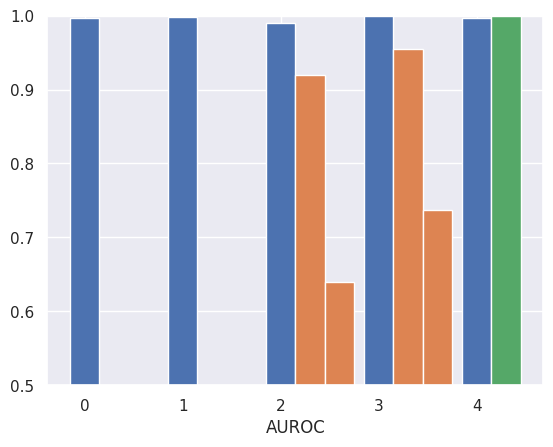

In [61]:
our_color, mns_color, ulp_color = sns.color_palette()[:3]

ROCS_TO_PLOT = [
    "random_border_pos_pattern",
    "center_pattern_ood",
    "simple_pattern_ood",
    "random_noise",
    "ulp_test_ood",
]



ax = plt.gca()

bar_width = 0.3

x_ours = np.arange(5)
y_ours = [rocs[p] for p in ROCS_TO_PLOT]

x_mns = np.array([2, 2, 3, 3]) + [bar_width, 2*bar_width, bar_width, 2*bar_width]
y_mns = [
    reported_rocs["mns_jumbo_simple_pattern"],
    reported_rocs["mns_oneclass_simple_pattern"],
    reported_rocs["mns_jumbo_random_noise"],
    reported_rocs["mns_oneclass_random_noise"],
]

x_ulp = np.array([4]) + [bar_width]
y_ulp = [reported_rocs["ulp"]]

ax.bar(x_ours, y_ours, width=bar_width, label="Ours", color=our_color)
ax.bar(x_mns, y_mns, width=bar_width, label="MNS", color=mns_color)
ax.bar(x_ulp, y_ulp, width=bar_width, label="ULP", color=ulp_color)


ax.set_xlabel("AUROC")


ax.set_ylim((0.5, 1))

#ax.set_yticks(x_ours)
#ax.set_yticklabels([PLOT_NAMES[ptype] for ptype in ROCS_TO_PLOT])
#ax.set_xticklabels(PLOT_NAMES.values(), rotation=90)
#ax.set_xticks(range(len(POISON_TYPES)))

#plt.tight_layout()
#plt.savefig(figdir + "backdoors_roc.pdf", bbox_inches="tight")

### Comparison to CTC

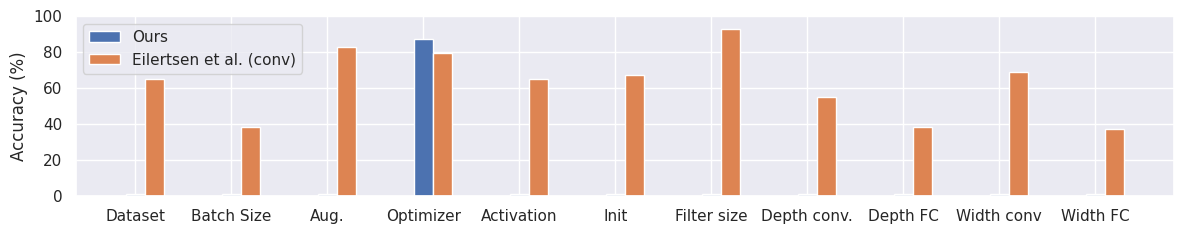

In [ ]:
# first, remake ctc bar chart by copying their results by hand. then, next to every bar put our own results

ctc_conv_results = {
    "Dataset": 65,
    "Batch Size": 38,
    "Aug.": 83,
    "Optimizer": 79.5,
    "Activation": 65,
    "Init": 67,
    "Filter size": 93,
    "Depth conv.": 55,
    "Depth FC": 38,
    "Width conv": 69,
    "Width FC": 37,
}


our_results = {
    "Dataset": 1,
    "Batch Size": 1,
    "Aug.": 1,
    "Optimizer": 87,
    "Activation": 1,
    "Init": 1,
    "Filter size": 1,
    "Depth conv.": 1,
    "Depth FC": 1,
    "Width conv": 1,
    "Width FC": 1,
}

plt.figure(figsize=(12, 2.5))
group_positions = np.arange(len(ctc_conv_results.keys()))
group_labels = ctc_conv_results.keys()


bar_width = 0.2
ax = plt.gca()
ax.bar(group_positions, our_results.values(), width=bar_width, label="Ours")
ax.bar(group_positions+bar_width, ctc_conv_results.values(), width=bar_width, label="Eilertsen et al. (conv)")
ax.set_xticks(group_positions)
ax.set_xticklabels(group_labels)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()

figpath = "../../writeups/iclr-2023/figures/ctc-comparison.pdf"
plt.savefig(figpath, bbox_inches="tight")